In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion

from gammapy.data import EventList
from gammapy.datasets import MapDataset
from gammapy.irf import PSFMap, EDispKernelMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SuperExpCutoffPowerLaw4FGLSpectralModel,
    create_fermi_isotropic_diffuse_model,
)
from gammapy.modeling import Fit

In [2]:
dataset_names = ['low_energy', 'med_energy', 'hi_energy']
main_path = '/home/woody/caph/mppi062h/woody_output/final/fermilat/'
iso_list = ['iso_P8R3_ULTRACLEANVETO_V3_v1.txt', 'iso_P8R3_ULTRACLEANVETO_V3_v1.txt', 'iso_P8R3_SOURCE_V3_v1.txt']

N_bin_met = 8
radius_list = [12, 5, 5]
dataset_e_edges = [100, 600, 4e3, 1e6] #u.MeV

In [3]:
datasets_binmet = []
for dataset_idx, dataset_name in enumerate(dataset_names):
    datasets_binmet.append([])
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):
            folder = f'{main_path}/{dataset_name}/{n_bin_met}_bin_met'
            dataset = MapDataset.read(f'{folder}/fermi_dataset.fits')
            
            dataset.mask_safe = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
            dataset.mask_safe &= dataset.counts.geom.region_mask(f"galactic;circle(0, 0, {radius_list[dataset_idx]})")
            
            m1 = (dataset.counts.geom.axes['energy'].center.value > dataset_e_edges[dataset_idx])
            m2 = (dataset.counts.geom.axes['energy'].center.value < dataset_e_edges[dataset_idx+1])
            mask = m1 & m2
            dataset.mask_safe.data[~mask] = 0
            
            datasets_binmet[dataset_idx].append(dataset)

### checking the datasets

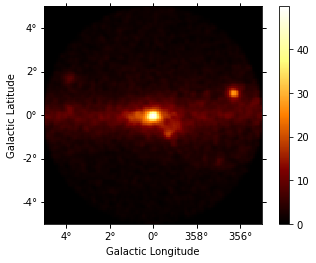

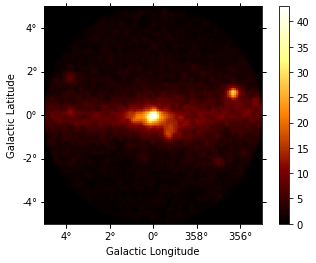

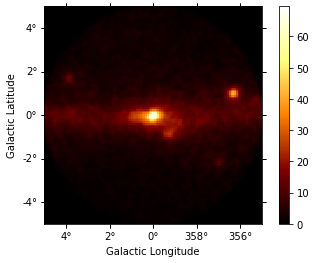

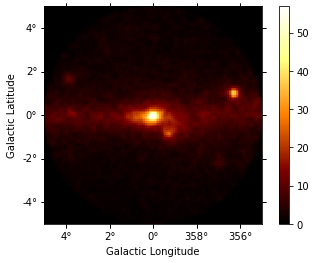

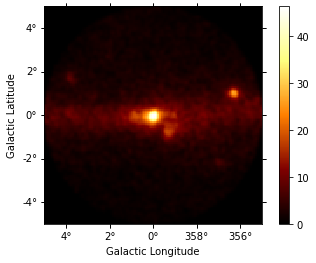

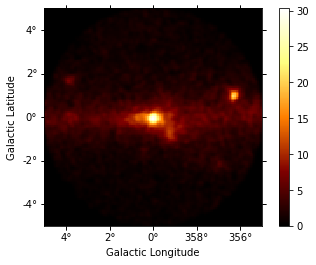

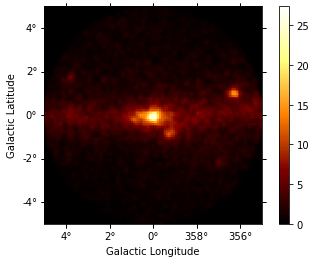

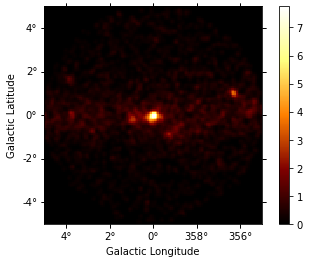

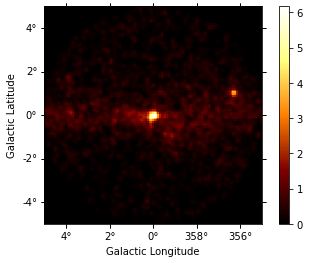

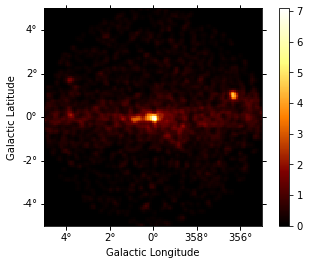

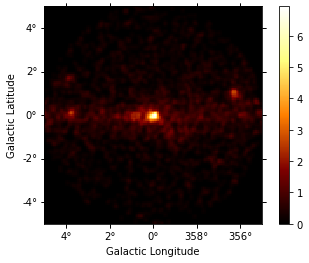

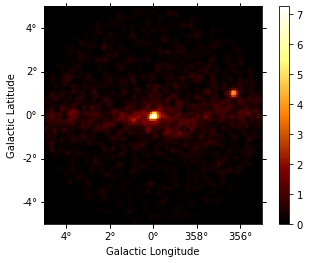

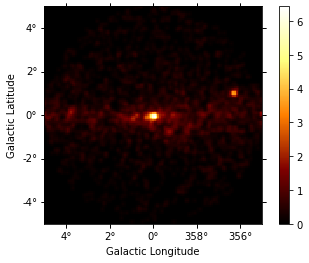

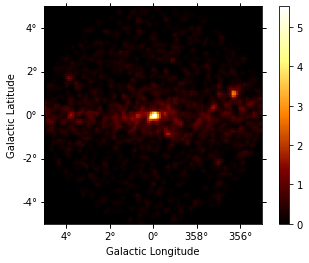

In [4]:
for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):
            datasets_binmet[dataset_idx][n_bin_met].counts.sum_over_axes().smooth(1).plot(add_cbar=True)
            plt.show()

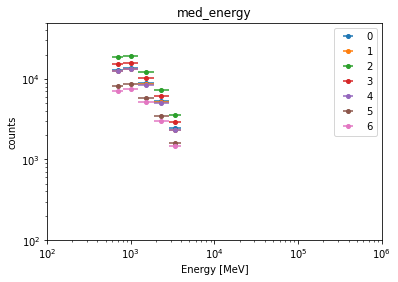

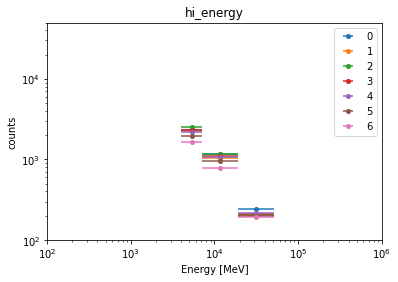

In [5]:
for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):
            on_region = CircleSkyRegion(center=SkyCoord(0,0, frame='galactic', unit='deg'), radius=5*u.deg)
            datasets_binmet[dataset_idx][n_bin_met].counts.get_spectrum().plot(label=n_bin_met)
        plt.title(dataset_name)
        plt.ylabel('counts')
        plt.ylim(1e2, 5e4)
        plt.legend()
        plt.show()

from the counts only, not considering any source, it seems like there is an increase of the counts for year 2, and then decrease again.
It is only for the whole skymap or is it for the central source?

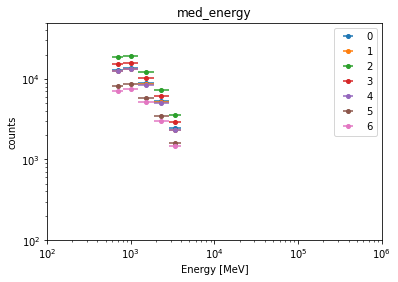

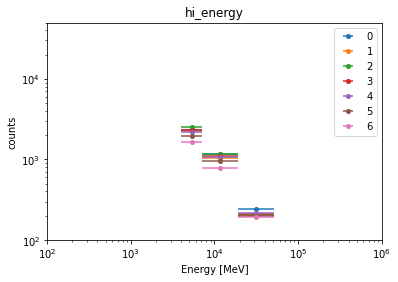

In [6]:
for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):
            on_region = CircleSkyRegion(center=SkyCoord(0,0, frame='galactic', unit='deg'), radius=0.1*u.deg)
            datasets_binmet[dataset_idx][n_bin_met].counts.get_spectrum().plot(label=n_bin_met)
        plt.ylim(1e2, 5e4)
        plt.title(dataset_name)
        plt.ylabel('counts')
        plt.legend()
        plt.show()

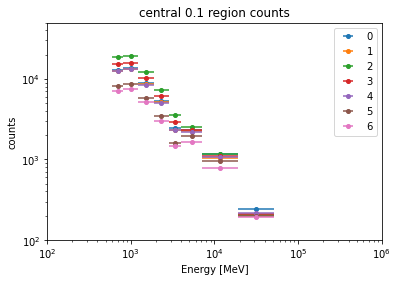

In [7]:
for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):
            on_region = CircleSkyRegion(center=SkyCoord(0,0, frame='galactic', unit='deg'), radius=0.1*u.deg)
            if dataset_idx == 1:
                label=n_bin_met
            else:
                label=None
            datasets_binmet[dataset_idx][n_bin_met].counts.get_spectrum().plot(label=label, color=f'C{n_bin_met}')
plt.ylim(1e2, 5e4)
plt.title('central 0.1 region counts')
plt.ylabel('counts')
plt.legend()
plt.show()

it seems like there is an increase and then a decrease for the central source

### loading catalog models

In [8]:
from gammapy.catalog import CATALOG_REGISTRY
from astropy.coordinates import Angle
from regions import CircleSkyRegion

geom = datasets_binmet[dataset_idx][n_bin_met].counts.geom
fgl = CATALOG_REGISTRY.get_cls("4fgl")()
inside_geom = (geom.drop('energy')).contains(fgl.positions)
idx = np.where(inside_geom)[0]

fermi_models = []
for i in idx:
    sig = float(fgl[i].info('more').split()[11])
    mo = fgl[i].sky_model()
    if (sig > 20):
        if mo.name != '4FGL J1745.6-2859':
            mo.parameters.freeze_all()
            mo.parameters['amplitude'].frozen=False
        fermi_models.append(mo)
        print(i)
initial_model = fermi_models

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),


4054


/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),


4172
4176
4179
4182
4186


/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/catalog/fermi.py:429: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),


4197
4239


In [9]:
len(initial_model)

8

In [10]:
diffuse_galactic_fermi = Map.read('gll_iem_v07.fits')
diffuse_galactic_fermi.unit = "cm-2 s-1 MeV-1 sr-1"
template_diffuse = TemplateSpatialModel(diffuse_galactic_fermi, normalize=False)

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
)
initial_model.append(diffuse_iem)

for dataset_idx, dataset_name in enumerate(dataset_names):
    initial_model_copy = initial_model.copy()
    
    filename = f'{main_path}/{dataset_name}/{iso_list[dataset_idx]}'
    diffuse_iso = create_fermi_isotropic_diffuse_model(
    filename=filename, interp_kwargs={"fill_value": None})
    initial_model_copy.append(diffuse_iso)
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):
            datasets_binmet[dataset_idx][n_bin_met].models = initial_model_copy       

In [13]:
dataset_idx = 1
dataset_fermi = datasets_binmet[dataset_idx][3]

<timed exec>:13: RuntimeWarning: invalid value encountered in true_divide


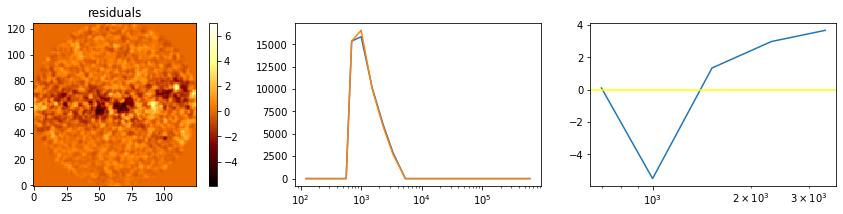

CPU times: user 4min 19s, sys: 2min 19s, total: 6min 38s
Wall time: 6min 37s


In [14]:
%%time

fig, ax = plt.subplots(1,3, figsize=(15, 3))
((dataset_fermi.counts-dataset_fermi.npred())*dataset_fermi.mask_safe).sum_over_axes().smooth(1).plot(add_cbar=True, ax=ax[0])
ax[0].set_title('residuals')

x_axis = dataset_fermi.counts.geom.axes['energy'].center
c = np.sum((dataset_fermi.counts*dataset_fermi.mask_safe).data, axis=(1,2))
b = np.sum((dataset_fermi.npred()*dataset_fermi.mask_safe).data, axis=(1,2))

ax[1].plot(x_axis, c)
ax[1].plot(x_axis, b)
ax[1].set_xscale('log')

error= (c-b)/np.sqrt(b)
ax[2].plot(x_axis, error)
ax[2].set_xscale('log')
ax[2].axhline(0, color='yellow')
plt.show()

In [19]:
%%time

result0= Fit().run(datasets=[dataset_fermi])
print(result0)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 688
	total stat : 68905.53

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 688
	total stat : 68905.53


CPU times: user 1min 27s, sys: 15.1 s, total: 1min 42s
Wall time: 1min 42s


<timed exec>:13: RuntimeWarning: invalid value encountered in true_divide


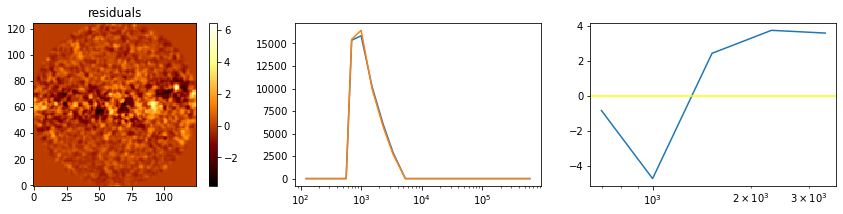

CPU times: user 1.14 s, sys: 111 ms, total: 1.25 s
Wall time: 1.01 s


In [21]:
%%time

fig, ax = plt.subplots(1,3, figsize=(15, 3))
((dataset_fermi.counts-dataset_fermi.npred())*dataset_fermi.mask_safe).sum_over_axes().smooth(1).plot(add_cbar=True, ax=ax[0])
ax[0].set_title('residuals')

x_axis = dataset_fermi.counts.geom.axes['energy'].center
c = np.sum((dataset_fermi.counts*dataset_fermi.mask_safe).data, axis=(1,2))
b = np.sum((dataset_fermi.npred()*dataset_fermi.mask_safe).data, axis=(1,2))

ax[1].plot(x_axis, c)
ax[1].plot(x_axis, b)
ax[1].set_xscale('log')

error= (c-b)/np.sqrt(b)
ax[2].plot(x_axis, error)
ax[2].set_xscale('log')
ax[2].axhline(0, color='yellow')
plt.show()

In [20]:
print(dataset_fermi.models)

DatasetModels

Component 0: SkyModel

  Name                      : 4FGL J1732.5-3131
  Datasets names            : None
  Spectral model type       : SuperExpCutoffPowerLaw4FGLSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   8.10e-12   +/- 3.5e-13 1 / (cm2 MeV s)
    reference    (frozen)   :   2391.755       MeV         
    expfactor    (frozen)   :      0.014                   
    index_1      (frozen)   :      0.526                   
    index_2      (frozen)   :      0.667                   
    lon_0        (frozen)   :    263.145       deg         
    lat_0        (frozen)   :    -31.517       deg         

Component 1: SkyModel

  Name                      : 4FGL J1745.6-2859
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               : 

In [24]:
dataset_idx = 1

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:372: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


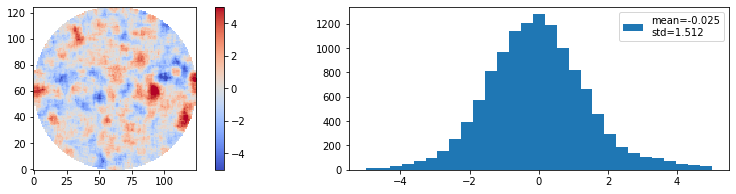

In [27]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.3 deg",
    selection_optional=[],
    energy_edges=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]] * u.MeV,
)
result = estimator.run(dataset_fermi)

fig, ax = plt.subplots(1,2, figsize=(15, 3))
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
data=result["sqrt_ts"].data.ravel()
ax[1].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
plt.legend()

In [ ]:
from gammapy.estimators import FluxPoints, FluxPointsEstimator

fp_central = FluxPointsEstimator(
    energy_edges=dataset_fermi.counts.geom.axes['energy'].edges,
    source="4FGL J1745.6-2859",
).run([dataset_fermi])

In [ ]:
x_axis = dataset_fermi.counts.geom.axes['energy'].center.value
energy_bounds = [dataset_e_edges[0], dataset_e_edges[-1]] * u.MeV
sed_type = "e2dnde"

for s, fp in zip(['4FGL J1745.6-2859'], [fp_central]):
    plt.figure(figsize=(8, 6))

    ax = dataset_fermi.models[s].spectral_model.plot(
        energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
    dataset_fermi.models[s].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
    fp.plot(ax=ax, sed_type=sed_type, label="dataset_fermi")
    ax.set_xlim(energy_bounds)
    plt.legend();

    plt.show()

In [ ]:
print('oi')